In [1]:
# install sompy
# !pip install minisom

# Source and documentation:
# https://github.com/JustGlowing/minisom/

In [2]:
from IPython.display import YouTubeVideo

from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram

from minisom import MiniSom

In [3]:
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver
plt.rcParams['figure.dpi'] = 50

## Import preprocessed data

In [4]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [5]:
df.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376


In [6]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x_education_2nd Cycle', 'x_education_Graduation', 'x_education_Master',
       'x_education_PhD', 'x_status_Married', 'x_status_Single',
       'x_status_Together', 'x_status_Widow', 'x_gender_M', 'x_dependents_1.0',
       'x_description_Kind of OK', 'x_description_Meh...',
       'x_description_OK nice!', 'x_description_Take my money!!', 'PC0', 'PC1',
       'PC2'],
      dtype='object')

In [7]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## Self-organizing maps
What is a SOM? How does it work? What is it used for?

The SOM objective is to adjust the units to the data in the input space, so that the
network is (as best as possible) representative of the training dataset.

### How is it computed?
### Important concepts:
- Units and observations
- BMU
- Neighborhood function
- Input and Output space

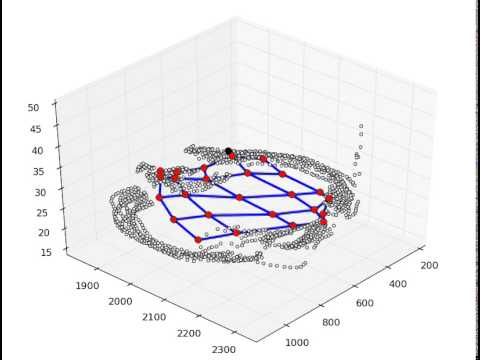

In [8]:
YouTubeVideo('k7DK5fnJH94')

### Characteristics:
- Grid shape needs to be set a priori
- Results depend on the initialization (even tough it can be quite robust to it)
- Fitting a SOM can be computationally expensive
- Capable of finding the global optimum (theoretically - if the LR -> 0)
- Visualization tool for high-dimensional data

### Additional analyses/tutorials
- [Air Flights](https://github.com/sevamoo/SOMPY/blob/master/sompy/examples/AirFlights_hexagonal_grid.ipynb)
- [Visualizations on toy datasets](https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11)

### How to apply Self-Organizing Maps?

The training of a SOM is **more effective** if it is done in two phases: the unfolding phase, and the fine-tuning phase. 

In the **unfolding phase** the objective is to **spread the units** in the region of the input space where the data patterns are located. In this phase the neighbourhood function should have a large initial radius so that all units have high mobility and the map can quickly cover the input space.

The **fine tuning phase**, as the name implies, is the process of small adjustments in order to **reduce the quantization error**, and centre the units in the areas where the density of patterns is highest. Usually, in this phase the learning rate and the neighbourhood radius are smaller than the ones used in the unfolding phase. As these two parameters are smaller, the map will need more time to adjust its weights and that is why the number of iterations or epochs is normally higher.

**Exercise**
- Train a SOM with a 10x10 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations
    - `minisom` does not distinguish between unfolding and fine tuning phase;

In [9]:
M = 10
N = 10
sm = MiniSom(M, N, # 10x10 map size
             len(metric_features), # Number of the elements of the vectors in input.
             learning_rate=.7, 
             activation_distance='euclidean',
             topology='hexagonal', 
             neighborhood_function='gaussian', 
             random_seed=42
             )

#sm.pca_weights_init(df[metric_features].values) # produces smoother gradient
sm.random_weights_init(df[metric_features].values)

#sm.train(df[metric_features].values, 1000)
#sm.train_random(df[metric_features].values, 200)

sm.train_batch(df[metric_features].values, 1000)

In [10]:
weights = sm.get_weights()
weights.shape

(10, 10, 10)

### Component planes
What do they represent? What kinds of information do they contain?

Analyse these plots from the following perspectives:
- Feature importance
- Feature correlation (both globally and locally)
- Data distribution
- Outlier detection

In [11]:
## Calculate the coordinates of the hexagons in the lattice
xx, yy  = sm.get_euclidean_coordinates()

In [12]:
##################################
## Visualizing Component Planes ##
##################################

def plot_component_planes(xx=xx, yy=yy, 
                          weights=weights, 
                          features=metric_features,
                          figsize=(20,20),
                          figlayout=(3,4),
                          title="Component Planes",
                          cmap=cm.magma
                         ):

    fig = plt.figure(figsize=figsize, constrained_layout=False)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), 
                                         vmax=np.max(weights))


    for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):

        sf.suptitle(features[cpi], y=0.95)

        axs = sf.subplots(1,1)
        axs.set_aspect('equal')

        ## Normalize color scale to range of values
        #colornorm = mpl_colors.Normalize(vmin=np.min(weights[:,:,cpi]), 
        #                                 vmax=np.max(weights[:,:,cpi]))

        # iteratively add hexagons
        for i in range(weights.shape[0]):
            for j in range(weights.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), 
                                     numVertices=6, 
                                     radius=.99 / np.sqrt(3),
                                     facecolor=cmap(colornorm(weights[i, j, cpi])), 
                                     alpha=1, 
                                     edgecolor=cmap(colornorm(weights[i, j, cpi]))
                                    )
                axs.add_patch(hexagon)

        ## only run this block if matplotlib >= 3.6.x
        mplv = [int(i) for i in mplver.split('.')]
        if mplv[1] >= 6:
            ## Add colorbar
            divider = make_axes_locatable(axs)

            ax_cb = divider.append_axes("right", size="7%")#, pad="2%")

            ## Create a Mappable object
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])

            ## Create custom colorbar 
            cb1 = colorbar.Colorbar(ax_cb,
                                    orientation='vertical', 
                                    alpha=1,
                                    mappable=cmap_sm
                                    )
            cb1.ax.get_yaxis().labelpad = 16

            ## Add colorbar to plot
            sf.add_axes(ax_cb)



        ## Remove axes for hex plot
        axs.margins(.05)
        axs.axis("off")


    fig.suptitle(title)
    plt.show()




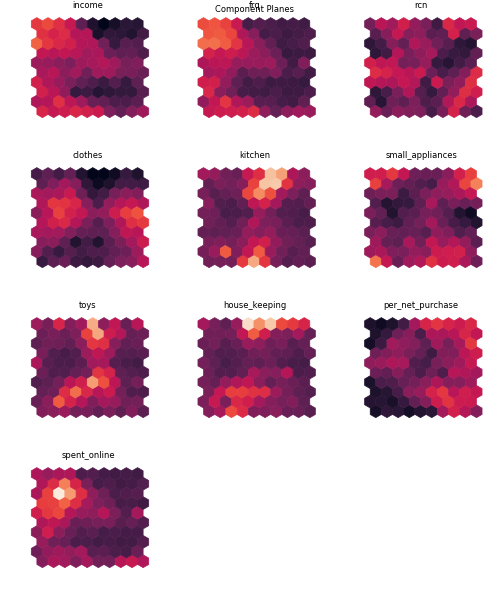

In [13]:

figsize=(10,12)

ncols = 4
nrows = np.ceil(len(metric_features)/ncols).astype(int)

figlayout = ncols, nrows


plot_component_planes(xx=xx, yy=yy, 
                      weights=weights, 
                      features=metric_features,
                      figsize=figsize,
                      figlayout=figlayout,
                      title="Component Planes",
                      cmap=sns.color_palette("rocket", as_cmap=True)
                    )

## U-matrix
Encode each neuron in the output space with the **average distance** to its neighbors in the input space.

Analyse these plots from the following perspectives:
- Clusters of units
- Pontential outliers (units which are very distant from its neighbors and have low frequency)

In [14]:
umatrix = sm.distance_map()
cmap = cm.RdYlBu_r

In [15]:
def plot_umatrix(xx, yy,
                 umatrix,
                 cmap,
                 figsize=(20,20),
                 annotate=False
                ):

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111)

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.95 / np.sqrt(3),
                                 facecolor=cmap(umatrix[i, j]), 
                                 alpha=1)
            ax.add_patch(hexagon)

            if annotate:
                ax.text(xx[(i, j)], wy, int(np.round(umatrix[i, j],2)*100), 
                        ha='center', va='center', 
                        fontsize=figsize[1], 
                        )

    ax.margins(.05)
    ax.axis("off")

    plt.title("UMatrix")

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0)    
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cmap, 
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('distance to neighbouring neurons',
                      rotation=270, fontsize=12)
    plt.gcf().add_axes(ax_cb)

    plt.show()

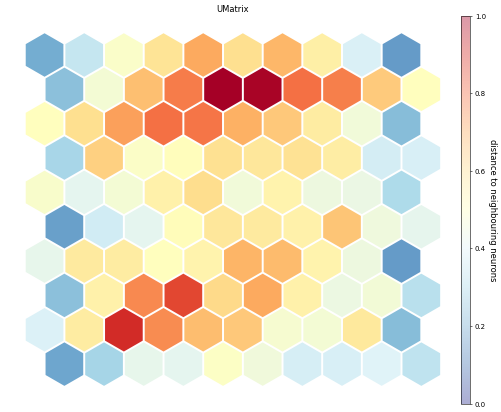

In [16]:
plot_umatrix(xx,yy,umatrix,cmap, figsize=(12,12))#, annotate=True)

### Hit-map
Show the **frequency** of each Unit in the output map

In [17]:
## Calculates how many data points have each neuron as BMU

hitsmatrix = sm.activation_response(df[metric_features].values)

In [18]:
print(hitsmatrix[4])

[ 44.  37.  70.  66.  85. 105.  43.  45.  37.  91.]


In [19]:
## HITSMATRIX

def plot_hitsmatrix(xx, yy,
                    hitsmatrix,
                    cmap=cm.Blues,
                    figsize=(10,10),
                    annotate=True
                   ):
    
    maxhits = hitsmatrix.max()
    fig, ax = plt.subplots(1,1,figsize=figsize)

    ax.set_aspect('equal')

    colornorm = mpl_colors.Normalize(vmin=np.min(hitsmatrix), 
                                     vmax=np.max(hitsmatrix))

    # iteratively add hexagons
    for i in range(hitsmatrix.shape[0]):
        for j in range(hitsmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hits = int(hitsmatrix[i, j])
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=.99 / np.sqrt(3),
                                 facecolor=cmap(colornorm(hits)), 
                                 edgecolor=cmap(colornorm(hits)), 
                                 alpha=1, 
                                )
            ax.add_patch(hexagon)
            if annotate & (hits > 0):
                textcolor = 'white' if colornorm(hits) > .65 else 'black'
                annot = str(hits) + " " + str(np.round(colornorm(hits),2))
                ax.text(xx[(i, j)], wy, hits, 
                        ha='center', va='center', 
                        fontsize=figsize[1], 
                        color=textcolor)


    ax.margins(.05)
    ax.axis("off")

    plt.title("Hits Map")


    ## Add colorbar
    divider = make_axes_locatable(ax)

    ax_cb = divider.new_horizontal(size="2%", pad=0)    

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 16

    ## Add colorbar to plot
    fig.add_axes(ax_cb)
    cb1.ax.set_ylabel('Hits Frequency',
                  rotation=270, fontsize=12)

    plt.show()

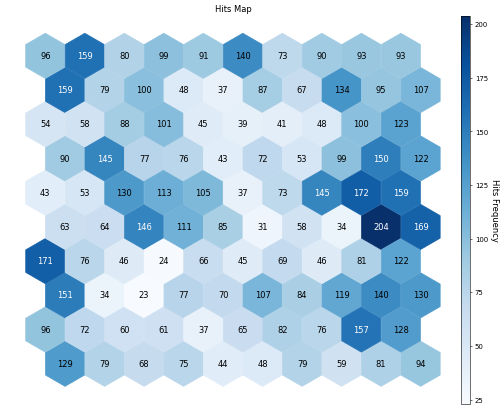

In [20]:
plot_hitsmatrix(xx,yy,hitsmatrix, annotate=True, figsize=(12,12))

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

**Exercise**
- Train a SOM with a 50x50 grid, random initialization, gaussian neighborhood function and hexagonal topology/lattice
- Set an unfolding phase and a fine tuning phase of 100 iterations

In [21]:
M = 50
N = 50
sm2 = MiniSom(M, N, # map size
             len(metric_features), # Number of the elements of the vectors in input.
             learning_rate=.7, 
             activation_distance='euclidean',
             topology='hexagonal', 
             neighborhood_function='gaussian', 
             random_seed=42
             )

#sm2.pca_weights_init(df[metric_features].values)
sm2.random_weights_init(df[metric_features].values)

## set verbose=True to get quantization error printed

#sm2.train_random(df[metric_features].values, 10000, verbose=True)

sm2.train_batch(df[metric_features].values, 100000, verbose=True)

#sm2.train(df[metric_features].values, 50000, verbose=True)


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.6067254188273511


In [22]:
# Coordinates of the units in the input space
#sm2.get_weights()

In [23]:
xx2, yy2 = sm2.get_euclidean_coordinates()


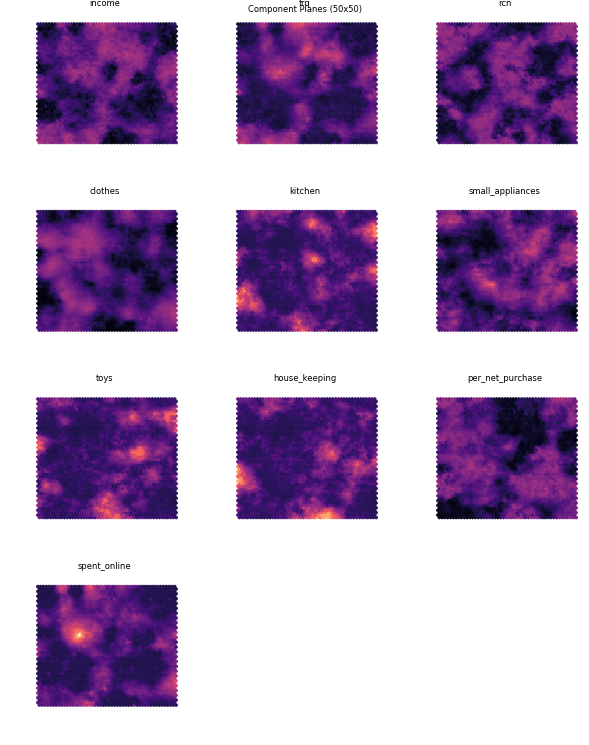

In [24]:
plot_component_planes(xx=xx2,yy=yy2,
                      weights=sm2.get_weights(),
                      features=metric_features,
                      figsize=(12,15),
                      figlayout=figlayout,
                      title="Component Planes ({}x{})".format(M,N)
                     )



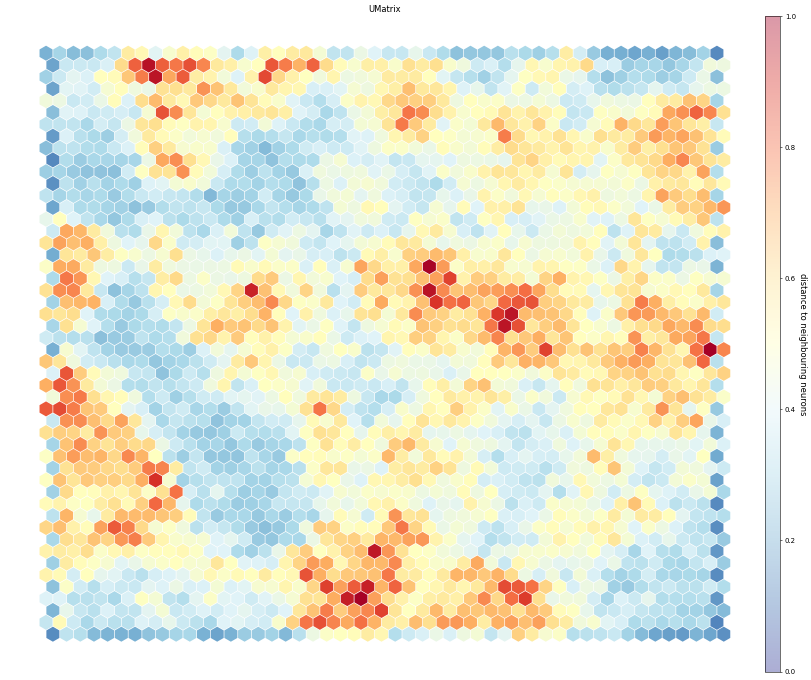

In [25]:
umatrix2 = sm2.distance_map()
plot_umatrix(xx2,yy2,umatrix2,cm.RdYlBu_r, figsize=(20,20))

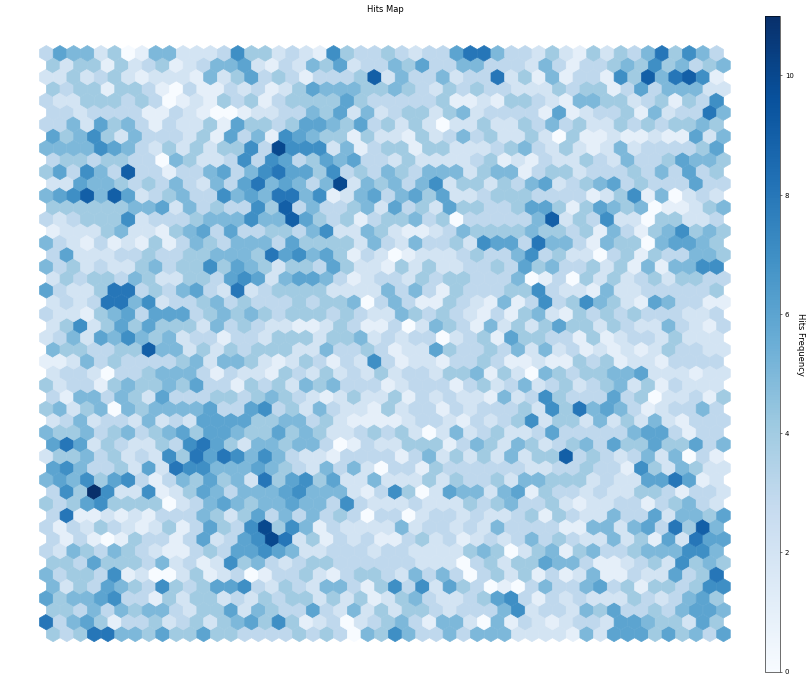

In [26]:
hitsmatrix2 = sm2.activation_response(df[metric_features].values)
plot_hitsmatrix(xx2,yy2,hitsmatrix2, annotate=False, figsize=(20,20))


Now we can have a better idea of how the input space look like in terms of distances.

### K-Means on top of SOM units
- Define number of clusters to retain

In [27]:
weights2 = sm2.get_weights()
weights_flat = weights2.reshape((M*N),weights2.shape[-1])


In [28]:
# Do the Inertia plot here (check last class' notebook)

In [29]:
range_clusters = range(1, 21)

inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(weights_flat)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution


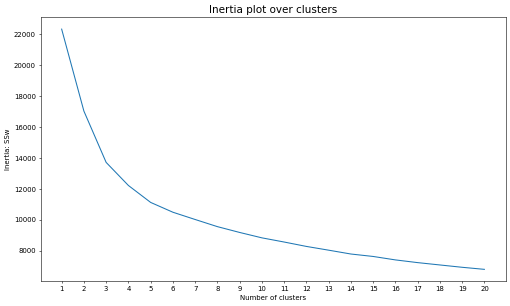

In [30]:
# The inertia plot
plt.figure(figsize=(12,7))
plt.plot(range_clusters, inertia)
plt.xticks(range_clusters)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)

plt.show()

In [31]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_weights() output)

## Flatten weights matrix to (MxN)x(features) 
K = 3
kmeans = KMeans(n_clusters=K, init='k-means++', n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(weights_flat)

# Each neuron's cluster label
cluster_labels


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [32]:
weights2.shape

(50, 50, 10)

In [33]:
weights_flat.shape

(2500, 10)

In [34]:
weights_flat[0]

array([ 1.98683246,  1.79656043, -0.62700932,  0.0307451 , -0.64425794,
        0.03135332,  0.65290782, -0.06027072, -1.6385658 ,  0.34310917])

In [35]:
## CLUSTERS
def plot_clusters(xx, yy, clusmatrix, k, title="Clusters", annotate=False):
    colors = [plt.cm.Set2(i) for i in range(k)]

    fig, ax = plt.subplots(1,1,figsize=(12,12))

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(clusmatrix.shape[0]):
        for j in range(clusmatrix.shape[1]):
            wy = yy[(i, j)] * np.sqrt(3) / 2
            hexagon = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=1 / np.sqrt(3),
                                 facecolor=colors[clusmatrix[i][j]], 
                                 alpha=.5, 
                                )
            ax.add_patch(hexagon)
            if annotate:
                ax.text(xx[(i, j)], wy, clusmatrix[i][j], ha='center', va='center', fontsize=8)


    ax.margins(.05)
    ax.axis("off")

    plt.title(title)

    plt.show()

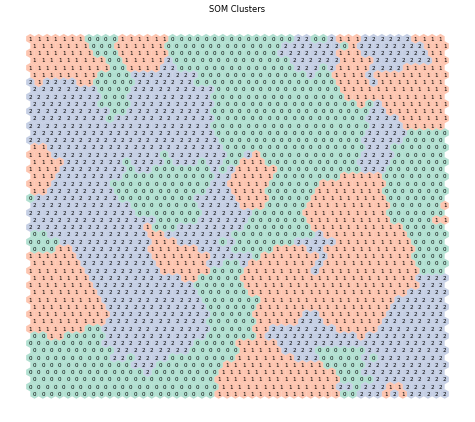

In [36]:
plot_clusters(xx2, yy2, cluster_labels.reshape(M,N), len(set(cluster_labels)), "SOM Clusters", annotate=True)

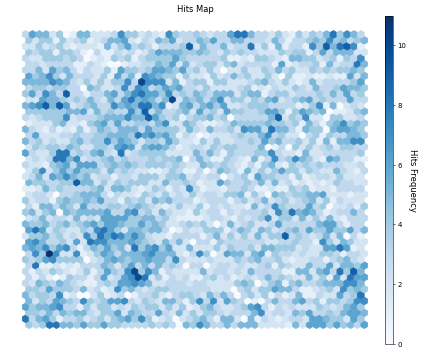

In [37]:
plot_hitsmatrix(xx2,yy2,hitsmatrix2, annotate=False)


### Hierarchical Clustering on top of SOM units
- Define best linkage method
- Define number of clusters to retain

In [38]:
# Do the R² plot here and the Dendrogram (check last class' notebook)

In [39]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

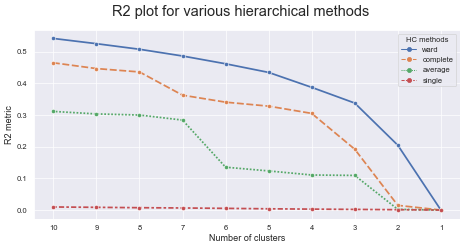

In [40]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=pd.DataFrame(weights_flat), link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [41]:
## Dendrogram

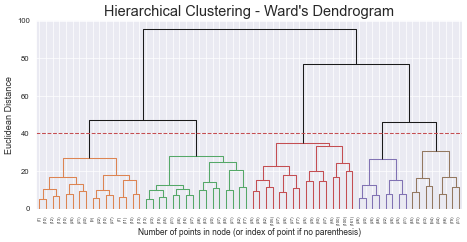

In [42]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(pd.DataFrame(weights_flat))

##########################
## Plot Dendrogram
##########################

# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 40
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

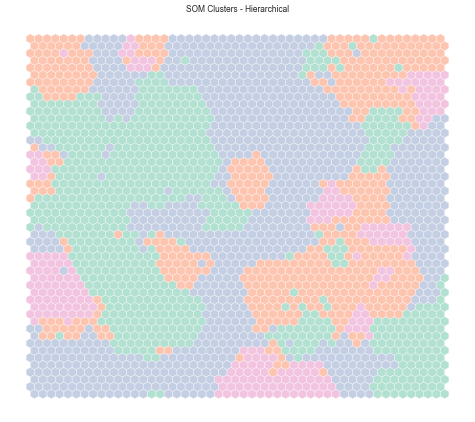

In [43]:
# Perform Hierarchical clustering on top of the 2500 untis (sm.get_node_vectors() output)
hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights_flat)

plot_clusters(xx2, yy2, nodeclus_labels.reshape(M,N), len(set(nodeclus_labels)), "SOM Clusters - Hierarchical")

### Final SOM Clustering solution

In [44]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,label
0,1.986832,1.796560,-0.627009,0.030745,-0.644258,0.031353,0.652908,-0.060271,-1.638566,0.343109,2
1,1.743999,2.064017,-0.899414,-0.073697,-0.469620,0.527581,-0.207841,-0.023879,-1.837915,0.004684,2
2,1.140569,1.296260,-0.604495,-0.294690,-0.255520,0.627064,0.553049,-0.404524,-1.702010,-0.012174,2
3,1.209765,1.448010,-0.669226,-0.188624,-0.596399,0.022577,0.194070,0.885063,-1.423506,0.499424,2
4,1.664246,1.613081,-1.472936,-0.512768,-0.246646,0.128784,0.195246,1.415557,-1.566897,0.360547,2
...,...,...,...,...,...,...,...,...,...,...,...
2495,-1.397244,-0.915239,1.469845,-1.451716,1.565237,0.841262,2.148853,-0.460369,1.099826,-0.888445,1
2496,-1.485821,-0.847850,1.134963,-0.735773,0.393238,0.832727,1.276967,-0.693508,1.206544,-0.883088,1
2497,-0.855005,-1.053334,0.777902,-0.294676,-0.023777,0.899348,-0.098086,-0.395044,0.531108,-0.947680,1
2498,-0.972691,-0.900172,1.158085,-0.824118,-0.301470,2.429177,-0.613931,-0.679890,0.898186,-0.898013,1


In [45]:
cluster_labels_mn = cluster_labels.reshape((M,N))

In [46]:
## Alternative method, mirroring SOMPY notebook
## Get intermediary info of index of the BMU for each data point


#bmu_iref = np.indices((M*N,)).reshape((M,N))
#bmu_index = np.array([sm2.winner(x) for x in df[metric_features].values])
#bmu_index_flat = np.array([bmu_iref[i[0],i[1]] for i in bmu_index])
#bmu_df = pd.DataFrame(bmu_index_flat, columns=['BMU'], index=df.index)

## Get cluster label of this BMU
#df_bmus = pd.concat([df, bmu_df], axis=1)
#df_bmus

#labels = pd.Series([cluster_labels_mn[i[0]][i[1]] for i in bmu_index], name='somlabel')


## Merge this cluster label into df
#df_final = pd.concat([df, labels], axis=1)
#df_final

In [47]:
# Obtaining SOM cluster labels 
# by getting the cluster labels of the BMU for each row 


bmu_index = np.array([sm2.winner(x) for x in df[metric_features].values])

labels = [cluster_labels_mn[i[0]][i[1]] for i in bmu_index]

df_final = pd.concat([
                df,
                pd.Series(labels, name='somlabel')
            ], axis=1
            )

df_final

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2,somlabel
0,0.743162,1.191605,0.457819,-0.617023,-0.243065,1.216847,0.495837,-0.499274,-1.257560,0.522055,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,1.937697,-1.120781,0
1,1.559488,1.100011,-1.535723,0.166160,-0.790228,0.740464,-0.374374,-0.631907,-1.798649,-0.237578,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,1.421498,-0.785625,0
2,-1.548542,-0.823463,0.557496,-0.834573,1.672006,-0.371096,-0.809480,2.286023,0.906799,-0.904191,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,-0.381440,0.780867,1
3,0.845528,0.550447,-1.402820,0.383710,0.440889,-0.768082,-0.084304,-0.234007,-0.391816,0.785568,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,0.514177,1.302203,0
4,0.782435,1.008417,-0.871209,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,-0.445925,1.237135,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,0.704805,0.443376,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,0.618993,0.458853,-1.701851,0.209670,0.167308,-0.132905,0.205767,-0.764540,0.257492,1.275517,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,0.372854,0.982963,0
8813,0.874744,0.733635,-1.701851,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,0.690363,1.865248,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,-0.083121,1.428619,2
8814,-0.455617,-0.731869,-1.535723,0.079139,-0.106274,-0.053508,0.060732,-0.101374,1.556107,-0.801266,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,-1.301747,0.423851,2
8815,-0.596155,0.825229,0.657173,-0.442982,0.577680,0.581670,-0.809480,0.561792,-0.608252,0.801051,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,0.959962,-0.332242,0


In [48]:
# Characterizing the final clusters
df_final.groupby('somlabel').mean()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_status_Widow,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2
somlabel,,,,,,,,,,,,,,,,,,,,,
0,1.056255,1.066802,-0.069457,-0.269593,0.064548,0.409339,0.067443,0.016076,-1.046395,0.666480,...,0.111691,0.639875,0.347251,0.080028,0.090466,0.463466,0.366040,1.137345,1.651043,-0.139928
1,-1.031938,-0.849046,0.101549,-0.985955,0.757023,0.473662,0.763231,0.784287,0.697281,-0.773706,...,0.010179,0.646580,0.852199,0.331840,0.328583,0.328176,0.001221,-2.406175,0.049620,0.002089
2,-0.143744,-0.281254,-0.014277,0.916638,-0.586395,-0.670993,-0.593154,-0.565647,0.371327,-0.004371,...,0.025523,0.644393,0.926584,0.289074,0.279323,0.351878,0.075423,0.757338,-1.395745,0.113858


## Analysing the appropriateness of our solution
### R²

In [49]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[metric_features])  # get total sum of squares
ssw_labels = df_final[metric_features.to_list() + ["somlabel"]].groupby(by='somlabel').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.3954246401611664

### Quantization error:
The quantization error is given by the average distance between a unit and the data points mapped to it i.e. all the input data points that share it as BMU.

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$
, where:

$Q$ is the overall quantization error of SOM,

$q_e$ is the quantization error for unit $e$,

$x_i$ is a data point/ observation,

$w_e$ is the unit $e$ representation in the input space,

$N_e$ is number of data points mapped to unit $e$,

$E$ is the number of units in the SOM grid